In [2]:
import numpy as np
import pandas as pd

# from data_generation import generate_gaussian_noises_dict, generate_sparse_response, generate_perturbed_response
# from Pursuit_Algorithms import AtomBaggingMatchingPursuit, BaggingAlgorithmBase

Generate data

In [2]:
# Use the functions to generate a Gaussian noise matrix and a sparse response
np.random.seed(0)
N = 100000
d = 300
m = 50
dictionary = generate_gaussian_noises_dict(N, d)
y, indices, coefficients = generate_sparse_response(dictionary, m)
noise_scale = 0.1
y_perturbed = generate_perturbed_response(y, noise_scale)

In [3]:
print('Real indices:', indices)
print('Real coefficients:', np.ravel(coefficients))

Real indices: [ 3582 60498 53227 21333  3885 51521 84261 10685 59948 41032 25747 44303
 83813 61991 49392 37116 65942  2216 81749 77996 30999 18294 81976 29876
 85471  8959 70029 28324 50521 89741  8350  4655 90049 66296 35416 50253
 46535 65667 56112 69884 69132 27954 45096 83141  7413 52692 27712 47173
 47393 87379]
Real coefficients: [ 1.87413779  0.630206   -0.24697655  0.85295699 -0.31762557 -0.95475304
 -0.33562075  1.55011843 -1.57176782 -1.3407682  -0.73598724  0.06443201
 -0.22466594 -0.26333802  0.834951    0.43156547  0.53180328  0.37411334
 -0.76095903  0.64069025 -0.60034938 -1.00010719  0.11934717  1.51143162
  1.04853558  0.53667196 -0.68620319 -0.40708522  0.69691247 -0.74340084
 -0.22861014 -1.77736584  0.72670967 -0.47673518  0.28419177 -0.77828999
 -1.234416   -0.21578628  0.55678469 -2.31688978  2.11890155  1.96910129
 -0.1081604   0.61521219 -0.92771841 -1.32325071 -1.64584385 -1.62347542
  0.28682219 -0.14946294]


In [19]:
class SignalBagging:
    def __init__(self, N, signal_bag_percent=0.7, replace_flag=True, random_seed=0):
        self.s = None
        self.phi = None
        self.N = N
        self.replace_flag = replace_flag
        self.random_seed = random_seed
        self.signal_bag_percent = signal_bag_percent
        self.s_bag = []
        self.phi_bag = []

    def fit(self, s, phi):
        self.s = s
        self.phi = phi

        num_samples = int(self.signal_bag_percent * len(self.s))
        np.random.seed(self.random_seed)
        for i in range(self.N):
            indices = np.random.choice(self.s.shape[0], num_samples, replace=self.replace_flag)
            s_tmp = self.s[indices]
            phi_tmp = self.phi[indices, :]
            self.s_bag.append(s_tmp)
            self.phi_bag.append(phi_tmp)
        
        return self.s_bag, self.phi_bag
    
    def change_seed(self, random_seed):
        self.random_seed = random_seed
        self.fit(self.s, self.phi)

test_case = BaggingAlgorithmBase(2, d, signal_bag_flag=True, signal_bag_percent=0.7, atom_bag_percent=1, select_atom_percent=0, replace_flag=True, agg_func='weight', random_seed=0)
test_case.fit(y_perturbed, dictionary)      

(array([0., 0., 0., ..., 0., 0., 0.]), None)

In [4]:
from algorithms import matching_pursuit, orthogonal_matching_pursuit

MP_a_perturb, MP_indices_perturb, MP_coefficients_perturb = matching_pursuit(y_perturbed, dictionary, m)

print('The indices for each step:', MP_indices_perturb)
print('The coefficients for each step:', MP_coefficients_perturb)

print("MSE:", np.mean((MP_a_perturb - y)**2))

The indices for each step: [68213, 95347, 66929, 83874, 50746, 93059, 31152, 4710, 32269, 83180, 3543, 99382, 87864, 73870, 52388, 75754, 31387, 11505, 15453, 76175, 81705, 98488, 14383, 52800, 32460, 83689, 98400, 55839, 86341, 64433, 95098, 41218, 57041, 15062, 85289, 26881, 97694, 72190, 61658, 85156, 76151, 88356, 27160, 57725, 9330, 49534, 90952, 68296, 3034, 46133]
The coefficients for each step: [array([[-3.82428949]]), array([[3.304088]]), array([[-3.2687966]]), array([[-3.05007277]]), array([[-3.1641814]]), array([[-2.92201234]]), array([[3.02829263]]), array([[-2.723313]]), array([[2.71599108]]), array([[2.71832705]]), array([[2.56385552]]), array([[2.39003285]]), array([[2.37953124]]), array([[-2.36164872]]), array([[2.27055679]]), array([[-2.01104587]]), array([[-2.05551466]]), array([[1.92628471]]), array([[-1.94981864]]), array([[1.83236218]]), array([[1.81962201]]), array([[-1.73457083]]), array([[1.72145975]]), array([[1.79227675]]), array([[1.65814687]]), array([[1.564

Now compared to our bagging pursuit algorithm

We arbitrarily choose hyperparameters for the bagging pursuit algorithm

- signal_bag_percent = 0.6 
- atom_bag_percent = 0.7
- select_atom_percent = 0.1

And test out 'N': number of submodels

In [5]:
from bagging_pursuit_functions import *

N_lst= [5, 10, 20, 50]
mse_test_lst = []

for N in N_lst:
    final_c, final_a, _, _, _, _ = bagging_matching_pursuit(y_perturbed, dictionary, m*2, N, signal_bag_percent = 0.6, atom_bag_percent=0.7, select_atom_percent=0.1)
    tmp_mse = np.mean((final_a - y)**2)
    mse_test_lst.append(tmp_mse)

In [8]:
mse_test_lst

[0.302894186554997,
 0.2691797221244791,
 0.26385939805460845,
 0.2493269159633969]

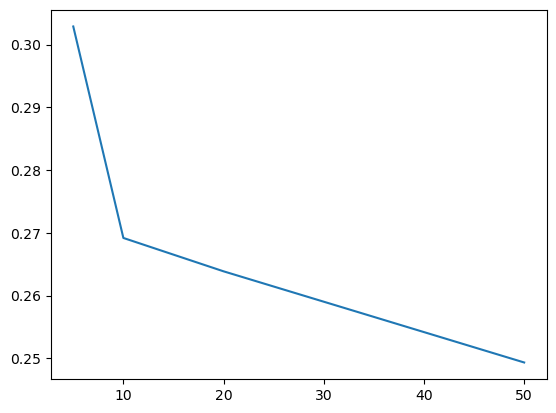

In [7]:
from matplotlib import pyplot as plt

plt.plot(N_lst, mse_test_lst)

In [1]:
import multiprocessing as mp
import os
import hydra
from omegaconf import DictConfig

In [2]:
@hydra.main(config_path='./Configs/', config_name='default_config',version_base='1.3')
def main(configs:DictConfig):
    MODEL_parameter = configs.MODEL
    print(MODEL_parameter)
    TEST_parameter = configs.TEST
    print(TEST_parameter)

main()


usage: ipykernel_launcher.py [--help] [--hydra-help] [--version]
                             [--cfg {job,hydra,all}] [--resolve]
                             [--package PACKAGE] [--run] [--multirun]
                             [--shell-completion] [--config-path CONFIG_PATH]
                             [--config-name CONFIG_NAME]
                             [--config-dir CONFIG_DIR]
                             [--experimental-rerun EXPERIMENTAL_RERUN]
                             [--info [{all,config,defaults,defaults-tree,plugins,searchpath}]]
                             [overrides ...]
ipykernel_launcher.py: error: argument --shell-completion/-sc: ignored explicit argument '9002'


AttributeError: 'tuple' object has no attribute 'tb_frame'

In [6]:
a

NameError: name 'a' is not defined

In [3]:
def get_parser():
    parser = argparse.ArgumentParser(description='Testing')
    parser.add_argument('--config-file', type=str, default='configs/defualt_config.yaml', metavar= "FILE" ,help='path to config file')
    parser.add_argument("--output", type=str, help="Output path")
    return parser


def get_cfg(config_file):
    with open(config_file, 'r') as f:
        config = yaml.safe_load(f)
    return config


def merge_cfg(default_config, input_config):
    for key in default_config.keys():
        if isinstance(default_config[key], dict):
            for subkey in default_config[key].keys():
                if subkey in input_config and input_config[subkey] is not None:
                    default_config[key][subkey] = input_config[subkey]
        elif key in input_config and input_config[key] is not None:
            default_config[key] = input_config[key]
    return default_config
    
    
def get_output_path(output_path, config_filename):
    if output_path is None:
        # output file will be a pickle file in the outputs folder
        output_path = os.path.join("outputs", config_filename.split("/")[-1].split(".")[0] + ".pkl")
    else:
        # output file will be a pickle file in the specified folder
        output_path = os.path.join(output_path, config_filename.split("/")[-1].split(".")[0] + ".pkl")
    return output_path


def run_test(config):
    print(config)
    return

def run_one_trial():
    return


# parser = get_parser()
# args = parser.parse_args()

# # Merge default config and input config
default_config = get_cfg("configs/default_config.yaml")
# input_config = get_cfg(args.config_file)
# config = merge_cfg(default_config, input_config)

# # Output path
# output_path = get_output_path(args.output, args.config_file)

# res = run_test(config)
# with open(output_path, 'wb') as f:
#     pkl.dump(res, f)
    

In [10]:
import argparse
import glob
import multiprocessing as mp
import os
import time
import yaml
import pickle as pkl
import itertools
import hashlib
import json
import pandas as pd
import numpy as np


In [11]:
def generate_params_combinations(config):
    # Delete TEST.trial_num from config
    del config['TEST']['trial_num']
    # Convert all values to lists.
    lists = {k: v if isinstance(v, list) else [v] for k, v in config.items()}
    # Generate combinations.
    keys, values = zip(*lists.items())
    combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    return combinations
def get_cfg(config_file):
    with open(config_file, 'r') as f:
        config = yaml.safe_load(f)
    return config

In [14]:
default_config = get_cfg("configs/default_config.yaml")
default_config

{'MODEL': {'method': 'MP',
  'bagging_sub_mum': 20,
  'depth': 50,
  'signal_bag_flag': True,
  'signal_bag_percent': 0.7,
  'atom_bag_percent': 0.7,
  'select_atom_percent': 0,
  'replace_flag': True,
  'agg_func': 'weight'},
 'TEST': {'trial_num': 10,
  'N': 100000,
  'd': 300,
  'true_sparsity': 25,
  'noise_level': [0, 0.01, 0.05, 0.1]}}

In [26]:
method_name = "BOMP"

match method_name:
    case "MP":
        print("MP")
    case "OMP":
        print("OMP")
    case _:
        print("No method")

No method
